# Comparing selected cells for melanoma response status classification
***
Jan T. Schleicher, 2022

In this notebook, we compare the selected cells for the distinction between respodner an non-responder melanoma lesions. Specifically, we compare DICSIT selected cells with cells that can be considered selected by scCODA, Wilcoxon rank-sum tests, or milo. This analysis is based on the data from [Sade-Feldman et al. 2018](https://doi.org/10.1016/j.cell.2018.10.038).

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
import upsetplot as up

%matplotlib inline
%config Completer.use_jedi = False

In [2]:
plot_dir = "../output/figures/melanoma_response_status"
os.makedirs(plot_dir, exist_ok=True)

## Load all the data

We load the results of the different analyses: scCODA simulation results, cell scores based on milo neighborhood analysis, and DICSIT filter responses

In [3]:
sccoda_results = pickle.load(open("../output/differential_abundance/melanoma_sccoda_results.pkl", "rb"))
sccoda_results.set_fdr(est_fdr=0.1)
cell_scores_milo = pd.read_csv("../output/differential_abundance/melanoma_cell_scores_milo.csv")
differential_abundance = pd.read_csv("../output/differential_abundance/melanoma_differential_abundance_wilcoxon.csv",
                                     index_col=0)
response_df = pd.read_csv("../output/filter_responses/melanoma_response_status_filter_response.csv",
                          index_col=0)\
    .reset_index().rename(columns={"Row.names": "cell"})
meta_data_umap = pd.read_csv("../data/melanoma_umap.txt", sep="\t", index_col=0)\
    .reset_index().rename(columns={"index": "cell"})

## Determine selected cells for each method

In contrast to DICSIT, the other methods do not have a predefined notion of selected cells. For scCODA and Wilcoxon rank-sum tests, which operate on the level of whole clusters, we define all cells from significantly different clusters as selected cells. For milo, we use scores for individual cells computed from neighborhood scores analogously to the DICSIT filter response and set the same threshold of $0.3 \times (\text{maximum filter response})$, after splitting the scores into scores for non-responder and responder lesions.

In [4]:
fdr = .1
ratio_max_response = .3

In [5]:
differential_abundance["selected_wilcoxon_NR"] = (differential_abundance.padj < fdr) & \
    (differential_abundance.log2fc > 0)
differential_abundance["selected_wilcoxon_R"] = (differential_abundance.padj < fdr) & \
    (differential_abundance.log2fc < 0)
differential_abundance["selected_sccoda_NR"] = (sccoda_results.credible_effects().values) & \
    (differential_abundance.log2fc > 0)
differential_abundance["selected_sccoda_R"] = (sccoda_results.credible_effects().values) & \
    (differential_abundance.log2fc < 0)
differential_abundance

,cluster_index,cluster,log2fc,p,padj,selected_wilcoxon_NR,selected_wilcoxon_R,selected_sccoda_NR,selected_sccoda_R
0,0,G1,-2.158012,0.002407,0.013238,False,True,False,True
1,1,G2,0.578780,0.780688,0.780688,False,False,False,False
2,2,G3,2.065498,0.010422,0.028662,True,False,False,False
3,3,G4,1.278635,0.089436,0.157844,False,False,False,False
4,4,G5,-1.032665,0.100446,0.157844,False,False,False,False
5,5,G6,1.962359,0.005844,0.021429,True,False,True,False
6,6,G7,0.252103,0.290052,0.398822,False,False,False,False
7,7,G8,0.480612,0.372954,0.455833,False,False,False,False
8,8,G9,0.283632,0.635986,0.699584,False,False,False,False
9,9,G10,-1.860139,0.042104,0.092629,False,True,False,False


In [6]:
cell_scores_milo["selected_milo_NR"] = \
    (cell_scores_milo.score_NR > ratio_max_response * cell_scores_milo.score_NR.max())
cell_scores_milo["selected_milo_R"] = \
    (cell_scores_milo.score_R > ratio_max_response * cell_scores_milo.score_R.max())

In [7]:
response_df["selected_dicsit_R"] = \
    (response_df.response_filter_0 > ratio_max_response * response_df.response_filter_0.max())
response_df["selected_dicsit_NR"] = \
    (response_df.response_filter_1 > ratio_max_response * response_df.response_filter_1.max())
response_df["selected_dicsit_R_2"] = \
    (response_df.response_filter_2 > ratio_max_response * response_df.response_filter_2.max())

In [8]:
comp_df = meta_data_umap[["cell", "sample_name", "patient", "cluster", "response_status"]]\
    .merge(differential_abundance[["cluster", "selected_wilcoxon_NR", "selected_wilcoxon_R",
                                   "selected_sccoda_NR", "selected_sccoda_R"]], on="cluster")\
    .merge(cell_scores_milo[["cell", "selected_milo_NR", "selected_milo_R"]], on="cell")\
    .merge(response_df[["cell", "selected_dicsit_NR", "selected_dicsit_R"]], on="cell")
comp_df

,cell,sample_name,patient,cluster,response_status,selected_wilcoxon_NR,selected_wilcoxon_R,selected_sccoda_NR,selected_sccoda_R,selected_milo_NR,selected_milo_R,selected_dicsit_NR,selected_dicsit_R
0,A10_P1_M15,Post_P1,P1,G9,R,False,False,False,False,False,False,False,False
1,A10_P4_M15,Post_P1,P1,G9,R,False,False,False,False,False,False,False,False
2,A10_P5_M15,Post_P1,P1,G9,R,False,False,False,False,False,False,False,False
3,A11_P2_M15,Post_P1,P1,G9,R,False,False,False,False,False,False,False,False
4,A11_P6_M15,Post_P1,P1,G9,R,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14967,B7_P7_MMD7_L001_myeloid_enriched,Post_P19,P19,G4,R,False,False,False,False,False,False,False,False
14968,D9_P7_MMD7_L001_myeloid_enriched,Post_P19,P19,G4,R,False,False,False,False,False,False,False,False
14969,G12_P7_MMD7_L001_myeloid_enriched,Post_P19,P19,G4,R,False,False,False,False,False,False,False,False
14970,G8_P7_MMD7_L001_myeloid_enriched,Post_P19,P19,G4,R,False,False,False,False,False,False,False,False


## Upset plots

To quantify the size of overlaps and unique sets of selected cells between the different methods, we generate upset plots.

In [9]:
data_upset_R = up.from_indicators(indicators=comp_df.filter(regex="selected_.*_R").columns.tolist(), data=comp_df)
data_upset_NR = up.from_indicators(indicators=comp_df.filter(regex="selected_.*_NR").columns.tolist(), data=comp_df)

In [16]:
sns.set_theme(style="ticks", font_scale=1.1)

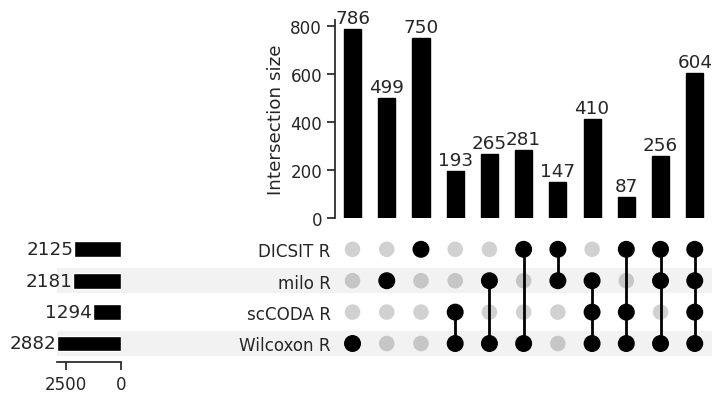

In [17]:
fig = plt.figure()
upset = up.UpSet(data_upset_R, min_degree=1, sort_categories_by=None, show_counts=True)
subplots = upset.plot(fig=fig)
subplots["intersections"].grid(visible=False)
subplots["totals"].grid(visible=False)
subplots["totals"].set_yticklabels(["Wilcoxon R", "scCODA R", "milo R", "DICSIT R"])
fig.savefig(os.path.join(plot_dir, "melanoma_selected_cells_R_upset.svg"))

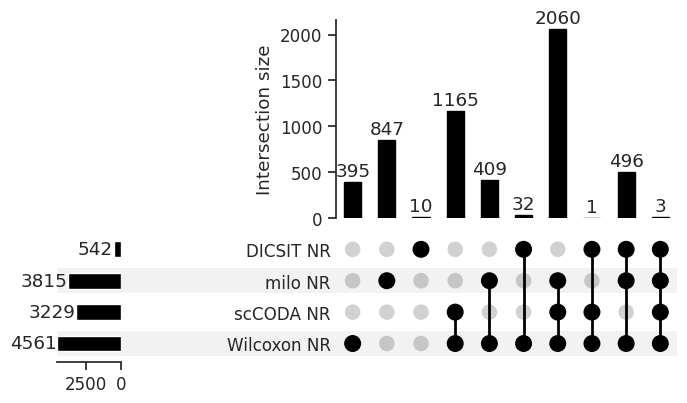

In [18]:
fig = plt.figure()
subplots = up.plot(data_upset_NR, min_degree=1, sort_categories_by=None, show_counts=True, fig=fig)
subplots["intersections"].grid(visible=False)
subplots["totals"].grid(visible=False)
subplots["totals"].set_yticklabels(["Wilcoxon NR", "scCODA NR", "milo NR", "DICSIT NR"])
fig.savefig(os.path.join(plot_dir, "melanoma_selected_cells_NR_upset.svg"))